In [69]:
# EEC 201 Final Project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from glob import glob
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [84]:
# Notch filter function
def notch_filter(audio_data, fs, notch_freq, Q):
    # Design the notch filter
    b, a = scipy.signal.iirnotch(notch_freq, Q, fs)
    # Apply the filter to the audio data
    filtered_audio = scipy.signal.filtfilt(b, a, audio_data)
    return filtered_audio


# MFCC Calculations

# Approach 1 - Fully automated using librosa's mfcc
def auto_MFCC(x, sr, fft_length, window_type, window_length, overlap, num_mels, num_mfcc, dct):
        
    #length_of_sample = len(x)
    fft_length
    hoplength = fft_length - overlap # Hop length is Window - Overlap. Part of a window with no overlap
    #max_STFT_matrix_size = np.floor(length_of_sample / hoplength) # Calculate the integer number of full windows

    mfcc = librosa.feature.mfcc(y=x, sr=sr, S=None, n_fft=fft_length, window=window_type, win_length=window_length, n_mels=num_mels, n_mfcc=num_mfcc, dct_type=dct, hop_length=hoplength, fmin=300, fmax=8000, htk=True, lifter=2*num_mfcc, norm='ortho')

    return mfcc

# Approach 2 - Manually Calculated following Haytham Fayek's guide
def manual_MFCC(y,sr):

    # Normalization
    # Normalize - Ampltidue
    #y = y / np.max(y)

    # Normalize - Energy
    y_energy = np.sum(y**2)
    scaling_fact = np.sqrt(1 / y_energy)
    y = (y * scaling_fact)

    
    # Pre-emphasize signal
    pre_emph = 0.97
    emphasized_signal = np.append(y[0], y[1:] - pre_emph*y[:-1])

    # Frame Blocking

    # Task 2 - Compute milliseconds in 256 samples
    num_samp = 256
    milli_sec = num_samp / sr
    #print(f'For a sampling rate of {sr}, 256 samples contains {milli_sec} ms of speech.')

    # Frame Blocking the signal
    frame_size = 0.04 # Seconds
    frame_stride = 0.02 # Seconds

    # Convert to samples
    frame_length = frame_size * sr
    hop_length = frame_stride * sr

    # Round to integers
    signal_length = int(len(emphasized_signal))
    frame_length = int(round(frame_length))
    hop_length = int(round(hop_length))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / hop_length))

    # Calculate Number of Frames
    pad_sig_length = num_frames * hop_length + frame_length
    z = np.zeros((pad_sig_length - signal_length))
    pad_sig = np.append(emphasized_signal,z)

    # Pad frames that are not full
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * hop_length, hop_length), (frame_length, 1)).T
    frames = pad_sig[indices.astype(np.int32, copy=False)]

    # Window the frame
    frames *= np.hamming(frame_length)
    #frames *= np.hanning(frame_length)

    # FFT and Power Spectrum Block
    nfft = 512

    mag_frames = np.absolute(np.fft.rfft(frames, nfft)) # Magnitude of FFT
    pow_frames = ((mag_frames)**2) * (1.0/(nfft)) # Power Spectrum

    # Mel Filter Banks Code
    num_filters = 40
    low_freq_mel = 300
    #high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700)) # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + (8000) / 700)) # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, num_filters + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((nfft + 1) * hz_points / sr)

    filter_bank = np.zeros((num_filters, int(np.floor(nfft / 2 + 1))))

    for m in range(1, num_filters + 1):
        f_m_minus = int(bin[m-1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m+1])

        for k in range(f_m_minus, f_m):
            filter_bank[m-1,k] = (k - bin[m-1]) / (bin[m] - bin[m-1])
        for k in range(f_m, f_m_plus):
            filter_bank[m-1,k] = (bin[m+1] - k) / (bin[m+1] - bin[m])

    filter_banks = np.dot(pow_frames, filter_bank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = np.log10(filter_banks) #* 20  # dB

    # Mean Normalization
    filter_banks -= (np.mean(filter_banks,axis=0) + 1e-8)

    # Compute the MFCCs
    num_mfccs = 12
    mfcc = scipy.fftpack.dct(filter_banks, type=2, axis=1,norm='ortho')[:,1:(num_mfccs+1)]

    # Liftering
    cep_lifter = 22
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift

    # Mean Normalization
    mfcc -= (np.mean(mfcc,axis=0) + 1e-8)

    return mfcc.T


In [91]:
# Implementing LBG

class LBG():

    # Average Distance

    def avg_dist(self, vectors, codebook):

        dim_col1 = vectors.shape[1]
        dim_col2 = codebook.shape[1]
        distances = np.empty((dim_col1,dim_col2))
        
        for j in range(dim_col2):

            centroid = codebook[:,j]

            for i in range(dim_col1):

                vector = vectors[:,i]
                distances[i,j] = np.linalg.norm(vector - centroid, axis=0)

        total_distance = np.sum(distances)
        avg_dist2 = np.argmin(distances,axis=1)*distances.T
        total_avg_dist = np.mean(avg_dist2)
        avg_dist3 = np.mean(distances)
        
        return distances, total_avg_dist, total_distance      # distances is a numpy array with rows = # of vectors, cols = # of centroids, value is euclidean distance of vector to centroid 
    

    # Nearest Neighbor -> New Centroid -> Codebook

    def new_codebook_func(self,features, distances, num_centroids):
        
        code_book = np.empty((len(features),num_centroids))    # <-- dimensions should be row = # of mels, cols = # of centroids
        nearest_centroid = np.argmin(distances,axis=1)
        for i in range(num_centroids):

            nearest_centroid = np.argmin(distances,axis=1)    # Nearest neigbor
            code_book[:,i] = np.mean(features[:,np.where(nearest_centroid == i)],2).T   # New Centroid
            #print(f'New Code Book Shape {code_book.shape}')
        return code_book
    

    # LBG algorithm
    def lbg(self, data, eps, des_centroids):

        # Initialize parameters
        num_centroids = 1
        distortion = 1
        codebook = np.mean(data,axis=1)

        while num_centroids < des_centroids:

            # Double codebook
            new_codebook = np.empty((len(data),num_centroids*2))
            #print(new_codebook.shape)
            if num_centroids == 1:

                new_codebook[:,0] = codebook * (1 + eps)
                new_codebook[:,1] = codebook * (1 - eps)

            else:

                for i in range(num_centroids):

                    new_codebook[:,2*i] = codebook[:,i] * (1 + eps)
                    new_codebook[:,2*i+1] = codebook[:,i] * (1 - eps)

            codebook = new_codebook
            #print(codebook.shape)
            num_centroids = np.shape(codebook)[1]
            #print(num_centroids)
            distances, previous_dist_avg, total_distortion = self.avg_dist(data, codebook)
            distortion = 1
            while np.abs(distortion) > eps:

                # nearest neighbor and distance
                codebook = self.new_codebook_func(data, distances, num_centroids)

                # clean up codebook NaN -> 0
                codebook = np.nan_to_num(codebook)

                # find new distances
                distances, new_dist_avg, total_distortion = self.avg_dist(data, codebook)
                distortions = np.sum(np.min(distances, axis=1)) / (np.shape(distances)[0])
                # find distortion
                distortion = (previous_dist_avg - distortions) / (previous_dist_avg)
                previous_dist_avg = distortions
                #print(f"Distorion: {abs(distortion)}")
                
        return codebook
    
    def train(self, train_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, epsilon, num_centroids, num_mel_banks):

        num_speakers_train = len(train_audio_files)
        codebooks = np.empty((num_speakers_train,num_mel_banks,num_centroids))

        for i in range(num_speakers_train):

            file = train_audio_files[i]
            y, sr = librosa.load(file, sr=48000)
            #y = y[np.abs(y) > 0.0000001]
            #y = notch_filter(audio_data= y, fs=48000, notch_freq=200, Q=4) # Notch filter 1
            #y = notch_filter(audio_data=y, fs=48000, notch_freq=800, Q=4) # Notch filter 2
            #y = notch_filter(audio_data=y, fs=48000, notch_freq=1000, Q=4) # Notch filter 3
            y_energy = np.sum(y**2)
            scaling_fact = np.sqrt(1 / y_energy)
            y_norm = (y * scaling_fact)
            #plt.plot(y_norm**2, label = f'Speaker {i}')
            #plt.legend(loc='upper right')
            #plt.show
            #mfcc = manual_MFCC(y=y_norm, fft_length=n_fft, overlap=overlap, sample_r = sr,num_mels=n_mels, num_mfcc=n_mfcc)
            mfcc = auto_MFCC(y_norm, sr, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct)
            #mfcc = mfcc[:-27]
            mfcc = np.delete(mfcc, 0, 0)
            mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
            #mfcc = normalize(mfcc, axis=0, norm='max')
            #mfcc = (mfcc.T / (np.max(mfcc,axis=1)**2)).T
            #print(mfcc.shape)
            codebooks[i,:,:] = self.lbg(mfcc,epsilon,num_centroids)
            #fig = plt.figure()
            #ax1 = fig.add_subplot(111)
            #ax1.scatter(mfcc[11,:], mfcc[5,:], s=10, c='b', marker="s", label=f'speaker{i}')
            #ax1.scatter(codebooks[i,11,:], codebooks[i,5,:], c='r', marker="o", label=f'codebook{i}')
            #plt.legend(loc='upper left')
            #plt.show()
            #print(f"Speaker {i} Codebook")

        return codebooks

    # Classify using the LBG model
    def classify(self, mfcc, codebook):

        min_dist = np.inf

        for i in range(np.shape(codebook)[0]):

            dist_arr = np.empty((1,np.shape(codebook)[0]))
            dist_matrix, distance_check, total_distortion_check = self.avg_dist(mfcc, codebook[i,:,:])
            #print(dist_matrix.shape)
            total_dist_check = np.sum(np.min(dist_matrix, axis=1)) / (np.shape(dist_matrix)[0])
            #print(f'{i} :{total_dist_check}')
            dist_arr[0,i] = total_dist_check
            if total_dist_check < min_dist:     # Original if total_dist_check < min_dist
                min_dist = total_dist_check           # Original min_dist = total_dist_check   
                speaker = i

        return speaker, dist_matrix
    
    # Predict using the LBG model
    def predict(self, test_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, codebooks):

        num_speakers_test = len(test_audio_files)
        classified_speakers = []
        correct_predictions = 0

        for i in range(num_speakers_test):

            file = test_audio_files[i]
            y, sr = librosa.load(file, sr=48000)
            #y = y[np.abs(y) > 0.0000001]
            #y = notch_filter(audio_data= y, fs=48000, notch_freq=200, Q=4) # Notch filter 1
            #y = notch_filter(audio_data=y, fs=48000, notch_freq=800, Q=4) # Notch filter 2
            #y = notch_filter(audio_data=y, fs=48000, notch_freq=1000, Q=4) # Notch filter 3
            y_energy = np.sum(y**2)
            scaling_fact = np.sqrt(1 / y_energy)
            y_norm = (y * scaling_fact)
            #mfcc = manual_MFCC(y=y_norm, fft_length=n_fft, overlap=overlap, sample_r = sr,num_mels=n_mels, num_mfcc=n_mfcc)
            mfcc = auto_MFCC(y_norm, sr, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct)
            #mfcc = mfcc[:-27]
            mfcc = np.delete(mfcc, 0, 0)
            mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
            #mfcc = normalize(mfcc, axis=0, norm='max')
            #mfcc = (mfcc.T / (np.max(mfcc,axis=1)**2)).T
            speaker, min_dist = self.classify(mfcc, codebooks)
            #print(min_dist.shape)
            #speak_dist_list.append(min_dist)
            print(f'Speaker {i} is {speaker}')
            classified_speakers.append(speaker)

            if speaker == i:

                correct_predictions += 1
            
        model_accuracy = correct_predictions / num_speakers_test
            
        return classified_speakers, model_accuracy



In [87]:
# Test 7

num_speakers_train = 11
num_speakers_test = 7
num_centroids = 512
num_mel_banks = 12
epsilon = 0.01

# Define MFCC parameters
sample_r = 48000
n_fft = 1440
window_type = 'hamming'
window_length = 1440
#overlap = round(window_length*0.3)
overlap = round(sample_r*0.01)
n_mels = 100
n_mfcc = num_mel_banks + 1
dct = 1

# Read in audio
train_audio_files = glob('../Project/Training_Data/*.wav')
test_audio_files = glob('../Project/Test_Data/*.wav')
#print(test_audio_files)
move_element = train_audio_files.pop(1) # Glob wrote into a list in alphabetic/numerical order. S10 and S11 are 2nd and 3rd in list. This caused PAIN.
train_audio_files.append(move_element)  # Moving S10 to end of list
move_element = train_audio_files.pop(1) # Glob wrote into a list in alphabetic/numerical order. S10 and S11 are 2nd and 3rd in list. This caused SUFFERING.
train_audio_files.append(move_element)  # Moving S11 to end of list
#print(train_audio_files)

# Instantiate class, train, and predict
lbg = LBG()
codebooks = lbg.train(train_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, epsilon, num_centroids, num_mel_banks)
clasifications_test7, accuracy_test7 = lbg.predict(test_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, codebooks)
print(accuracy_test7)

['../Project/Training_Data\\s1.wav', '../Project/Training_Data\\s10.wav', '../Project/Training_Data\\s11.wav', '../Project/Training_Data\\s2.wav', '../Project/Training_Data\\s3.wav', '../Project/Training_Data\\s4.wav', '../Project/Training_Data\\s5.wav', '../Project/Training_Data\\s6.wav', '../Project/Training_Data\\s7.wav', '../Project/Training_Data\\s8.wav', '../Project/Training_Data\\s9.wav']


C:\Users\Bishane\AppData\Local\Temp\ipykernel_45652\918173044.py:87: RuntimeWarning: invalid value encountered in scalar divide
  distortion = (previous_dist_avg - distortions) / (previous_dist_avg)


Speaker 0 is 0
Speaker 1 is 1
Speaker 2 is 2
Speaker 3 is 3
Speaker 4 is 4
Speaker 5 is 5
Speaker 6 is 6
1.0


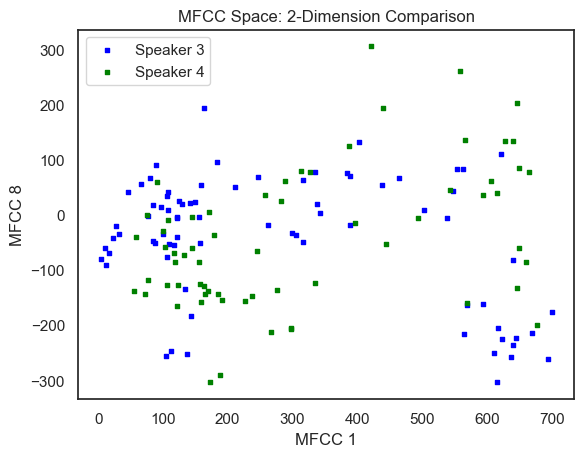

In [73]:
# Test 5
# Speaker 1 is 0, S2 is 1, etc.
file2 = test_audio_files[2]
y, sr = librosa.load(file2, sr=48000)
y_energy = np.sum(y**2)
scaling_fact = np.sqrt(1 / y_energy)
y_norm = (y * scaling_fact)
mfcc2 = auto_MFCC(y_norm, sr, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct)

file3 = test_audio_files[3]
y, sr = librosa.load(file3, sr=48000)
y_energy = np.sum(y**2)
scaling_fact = np.sqrt(1 / y_energy)
y_norm = (y * scaling_fact)
mfcc3 = auto_MFCC(y_norm, sr, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct)


# Scatter plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(mfcc2[1,:], mfcc2[8,:], s=10, c='b', marker="s", label='Speaker 3')
ax1.scatter(mfcc3[1,:], mfcc3[8,:], s=10, c='g', marker="s", label='Speaker 4')
plt.legend(loc='upper left')
plt.title('MFCC Space: 2-Dimension Comparison')
plt.xlabel('MFCC 1')
plt.ylabel('MFCC 8')
plt.show()


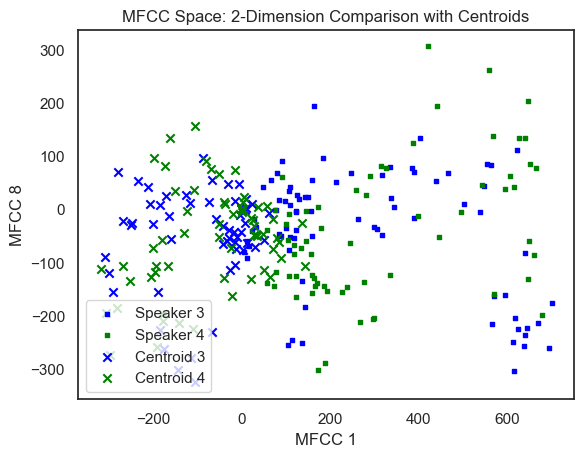

In [96]:
# Test 6

codes_speak_2 = codebooks[2,:,:]
codes_speak_3 = codebooks[3,:,:]

# Scatter plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(mfcc2[1,:], mfcc2[8,:], s=10, c='b', marker="s", label='Speaker 3')
ax1.scatter(mfcc3[1,:], mfcc3[8,:], s=10, c='g', marker="s", label='Speaker 4')
ax1.scatter(codes_speak_2[1,:], codes_speak_2[8,:], c='b', marker="x", label='Centroid 3')
ax1.scatter(codes_speak_3[1,:], codes_speak_3[8,:], c='g', marker="x", label='Centroid 4')
plt.legend(loc='lower left')
plt.title('MFCC Space: 2-Dimension Comparison with Centroids')
plt.xlabel('MFCC 1')
plt.ylabel('MFCC 8')
plt.show()

In [98]:
# Test 8 - Notch Filters

# LBG Parameters
num_speakers_train = 11
num_speakers_test = 7
num_centroids = 512
num_mel_banks = 12
epsilon = 0.01

# Define MFCC parameters
sample_r = 48000
n_fft = 1440
window_type = 'hamming'
window_length = 1440
#overlap = round(window_length*0.3)
overlap = round(sample_r*0.01)
n_mels = 100
n_mfcc = num_mel_banks + 1
dct = 1



# Read in given speech data
train_audio_files = glob('../Project/Training_Data/*.wav')
test_audio_files = glob('../Project/Test_Data/*.wav')
move_element = train_audio_files.pop(1) # Glob wrote into a list in alphabetic/numerical order. S10 and S11 are 2nd and 3rd in list. This caused PAIN.
train_audio_files.append(move_element)  # Moving S10 to end of list
move_element = train_audio_files.pop(1) # Glob wrote into a list in alphabetic/numerical order. S10 and S11 are 2nd and 3rd in list. This caused SUFFERING.
train_audio_files.append(move_element)  # Moving S11 to end of list


# Notch Filter 1
#lbg = LBG()
#codebooks = lbg.train(train_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, epsilon, num_centroids, num_mel_banks)
#clasifications_test8_1, accuracy_test8_1 = lbg.predict(test_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, codebooks)
#print(f'Accuracy Notch Filter 1 (200 Hz, 50 Hz Bandwidth Stopband): {accuracy_test8_1}')


# Notch Filter 2
#lbg = LBG()
#codebooks = lbg.train(train_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, epsilon, num_centroids, num_mel_banks)
#clasifications_test8_2, accuracy_test8_2 = lbg.predict(test_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, codebooks)
#print(f'Accuracy notch filter 2 (fc = 400 Hz, 100 Hz Bandwidth Stopband): {accuracy_test8_2}')


# Notch Filter 3
#lbg = LBG()
#codebooks = lbg.train(train_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, epsilon, num_centroids, num_mel_banks)
#clasifications_test8_3, accuracy_test8_3 = lbg.predict(test_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, codebooks)
#print(f'Accuracy notch filter 3 (800 Hz, 200 Hz Stopband): {accuracy_test8_3}')

print(f'Accuracy Notch Filter 1 (fc = 200 Hz, 50 Hz Bandwidth Stopband): {accuracy_test8_1}')
print(f'Accuracy notch filter 2 (fc = 800 Hz, 200 Hz Bandwidth Stopband): {accuracy_test8_2}')
print(f'Accuracy notch filter 3 (fc = 1000 Hz, 250 Hz Stopband): {accuracy_test8_3}')

Accuracy Notch Filter 1 (fc = 200 Hz, 50 Hz Bandwidth Stopband): 1.0
Accuracy notch filter 2 (fc = 800 Hz, 200 Hz Bandwidth Stopband): 1.0
Accuracy notch filter 3 (fc = 1000 Hz, 250 Hz Stopband): 1.0


In [76]:
 # Test 9

num_speakers_train = 11
num_speakers_test = 7
num_centroids = 512
num_mel_banks = 12
epsilon = 0.01

# Define MFCC parameters
sample_r = 48000
n_fft = 1440
window_type = 'hamming'
window_length = 1440
#overlap = round(window_length*0.3)
overlap = round(sample_r*0.01)
n_mels = 100
n_mfcc = num_mel_banks + 1
dct = 1

# Read in audio
train_audio_files = glob('../Project/Training_Data_Test9/*.wav')
test_audio_files = glob('../Project/Test_Data_Test9/*.wav')
#print(train_audio_files)
move_element = train_audio_files.pop(1) # Glob wrote into a list in alphabetic/numerical order. S10 and S11 are 2nd and 3rd in list. This caused PAIN.
train_audio_files.append(move_element)  # Moving S10 to end of list
move_element = train_audio_files.pop(1) # Glob wrote into a list in alphabetic/numerical order. S10 and S11 are 2nd and 3rd in list. This caused SUFFERING.
train_audio_files.append(move_element)  # Moving S11 to end of list
#print(train_audio_files)

# Instantiate class, train, and predict
lbg = LBG()
codebooks = lbg.train(train_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, epsilon, num_centroids, num_mel_banks)
clasifications_test9, accuracy_test9 = lbg.predict(test_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, codebooks)
print(accuracy_test9)

['../Project/Training_Data_Test9\\s1-Hello_Karm_training.wav', '../Project/Training_Data_Test9\\s2.wav', '../Project/Training_Data_Test9\\s3.wav', '../Project/Training_Data_Test9\\s4-test9-train-speaker1.wav', '../Project/Training_Data_Test9\\s5.wav', '../Project/Training_Data_Test9\\s6.wav', '../Project/Training_Data_Test9\\s7.wav', '../Project/Training_Data_Test9\\s8.wav', '../Project/Training_Data_Test9\\s9.wav', '../Project/Training_Data_Test9\\s10.wav', '../Project/Training_Data_Test9\\s11.wav']


C:\Users\Bishane\AppData\Local\Temp\ipykernel_45652\94449556.py:87: RuntimeWarning: invalid value encountered in scalar divide
  distortion = (previous_dist_avg - distortions) / (previous_dist_avg)


Speaker 0 is 0
Speaker 1 is 1
Speaker 2 is 2
Speaker 3 is 3
Speaker 4 is 4
Speaker 5 is 5
Speaker 6 is 6
1.0


In [78]:
# Test 10

num_speakers_train = 36
num_speakers_test = 36
num_centroids = 512
num_mel_banks = 12
epsilon = 0.01

# Define MFCC parameters
sample_r = 48000
n_fft = 1440
window_type = 'hamming'
window_length = 1440
#overlap = round(window_length*0.3)
overlap = round(sample_r*0.01)
n_mels = 100
n_mfcc = num_mel_banks + 1
dct = 1



# Twelve Sound Only
train_audio_files = glob('../Project/Class_Training_Twelve/*.wav')
test_audio_files = glob('../Project/Class_Testing_Twelve/*.wav')

# Instantiate class, train, and predict
lbg = LBG()
codebooks = lbg.train(train_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, epsilon, num_centroids, num_mel_banks)
clasifications_test10_12, accuracy_test10_12 = lbg.predict(test_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, codebooks)
print(f'Accuracy for twelve only: {accuracy_test10_12}')


# Zero Sound Only
train_audio_files = glob('../Project/Class_Training_Zero/*.wav')
test_audio_files = glob('../Project/Class_Testing_Zero/*.wav')

# Instantiate class, train, and predict
lbg = LBG()
codebooks = lbg.train(train_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, epsilon, num_centroids, num_mel_banks)
clasifications_test10_0, accuracy_test10_0 = lbg.predict(test_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, codebooks)
print(f'Accuracy for zero only: {accuracy_test10_0}')



# All files
# Read in audio
train_audio_files = glob('../Project/Class_Training/*.wav')
test_audio_files = glob('../Project/Class_Testing/*.wav')

# Instantiate class, train, and predict
lbg = LBG()
codebooks = lbg.train(train_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, epsilon, num_centroids, num_mel_banks)
clasifications_test10, accuracy_test10 = lbg.predict(test_audio_files, n_fft, window_type, window_length, overlap, n_mels, n_mfcc, dct, codebooks)
print(f'Accuracy for all samples {accuracy_test10}')


c:\Users\Bishane\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Bishane\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\Bishane\AppData\Local\Temp\ipykernel_45652\94449556.py:87: RuntimeWarning: invalid value encountered in scalar divide
  distortion = (previous_dist_avg - distortions) / (previous_dist_avg)


Speaker 0 is 0
Speaker 1 is 1
Speaker 2 is 2
Speaker 3 is 3
Speaker 4 is 4
Speaker 5 is 5
Speaker 6 is 6
Speaker 7 is 7
Speaker 8 is 8
Speaker 9 is 9
Speaker 10 is 10
Speaker 11 is 11
Speaker 12 is 12
Speaker 13 is 13
Speaker 14 is 14
Speaker 15 is 15
Speaker 16 is 11
Speaker 17 is 17
Accuracy for twelve only: 0.9444444444444444
Speaker 0 is 9
Speaker 1 is 8
Speaker 2 is 2
Speaker 3 is 3
Speaker 4 is 4
Speaker 5 is 8
Speaker 6 is 6
Speaker 7 is 7
Speaker 8 is 8
Speaker 9 is 9
Speaker 10 is 10
Speaker 11 is 13
Speaker 12 is 7
Speaker 13 is 13
Speaker 14 is 5
Speaker 15 is 15
Speaker 16 is 2
Speaker 17 is 17
Accuracy for zero only: 0.6111111111111112
Speaker 0 is 0
Speaker 1 is 1
Speaker 2 is 2
Speaker 3 is 3
Speaker 4 is 4
Speaker 5 is 5
Speaker 6 is 6
Speaker 7 is 7
Speaker 8 is 8
Speaker 9 is 9
Speaker 10 is 10
Speaker 11 is 11
Speaker 12 is 12
Speaker 13 is 13
Speaker 14 is 14
Speaker 15 is 15
Speaker 16 is 11
Speaker 17 is 17
Speaker 18 is 27
Speaker 19 is 26
Speaker 20 is 20
Speake

In [95]:
## Test 10 Results
print(f'Accuracy for twelve only: {accuracy_test10_12}')
print(f'Accuracy for zero only: {accuracy_test10_0}')
print(f'Accuracy for all samples {accuracy_test10}')

Accuracy for twelve only: 0.9444444444444444
Accuracy for zero only: 0.6111111111111112
Accuracy for all samples 0.7777777777777778
